# PyTorch Dataset Class

[Basics Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

[Medium Example](https://medium.com/fullstackai/how-to-train-an-object-detector-with-your-own-coco-dataset-in-pytorch-319e7090da5)

[Masks Example](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

From the reference above the dataset class must have three functions: __init__, __len__, and __getitem__.

__init__
The __init__ function is run once when instantiating the Dataset object. We initialize the directory containing the images, the annotations file, and both transforms (covered in more detail in the next section).

The __len__ function returns the number of samples in our dataset.

__getitem__
The __getitem__ function loads and returns a sample from the dataset at the given index idx. Based on the index, it identifies the image’s location on disk, converts that to a tensor using read_image, retrieves the corresponding label from the csv data in self.img_labels, calls the transform functions on them (if applicable), and returns the tensor image and corresponding label in a Python dict.
    
Let's build one for our dataset.

**NB** I created a dictionary of ID to Label, this will be different for our weak labelled data.

In [37]:
# imports
import pandas as pd
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

# transformers
from torchvision import transforms
from skimage.transform import rescale, resize, downscale_local_mean

# dataset imports
import os
import torch
import torch.utils.data
import torchvision

In [30]:
# Load data 
X = pd.read_csv('../input/image_subset/subset_train.csv')
X.Label = X['Label'].astype('int')
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3511 entries, 0 to 3510
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      3511 non-null   object
 1   Label   3511 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 41.3+ KB


Okay now our problem is we are matching the masks to our 4 channels. We should merge each 4 channel images to one image which has all 4 channels in one. We should also re scale the images using a transformer before placing into the model.

In [ ]:
# Conver to rgby

def convert_rgby_to_rgb(arr):
    """ Convert a 4 channel (RGBY) image to a 3 channel RGB image.
    
    Advice From Competition Host/User: lnhtrang

    For annotation (by experts) and for the model, I guess we agree that individual 
    channels with full range px values are better. 
    In annotation, we toggled the channels. 
    For visualization purpose only, you can try blending the channels. 
    For example, 
        - red = red + yellow
        - green = green + yellow/2
        - blue=blue.
        
    Args:
        arr (numpy array): The RGBY, 4 channel numpy array for a given image
    
    Returns:
        RGB Image
    """
    
    rgb_arr = np.zeros_like(arr[..., :-1])
    rgb_arr[..., 0] = arr[..., 0]
    rgb_arr[..., 1] = arr[..., 1]+arr[..., 3]/2
    rgb_arr[..., 2] = arr[..., 2]
    
    return rgb_arr

In [ ]:
id_s = X.ID
ROOT_DIR = '../input/image_subset/'
SAVE_DIR = '../input/image_subset/image/'
def get_image_array(path):
    # return np array of image path
    return(np.array(Image.open(path)))

for i_d in id_s:
    r = get_image_array('../input/image_subset/raw/'+i_d+'_red.png')
    g = get_image_array('../input/image_subset/raw/'+i_d+'_green.png')
    b = get_image_array('../input/image_subset/raw/'+i_d+'_blue.png')
    y = get_image_array('../input/image_subset/raw/'+i_d+'_yellow.png')
    
    arr = np.dstack((r,g,b,y))
    Image.fromarray(convert_rgby_to_rgb(arr)).save(SAVE_DIR+i_d+'.png')

Great now we have a new directory of RGBY converted RGB images. This will be our new directory for our dataset. Let's view a couple of them to show what I mean.

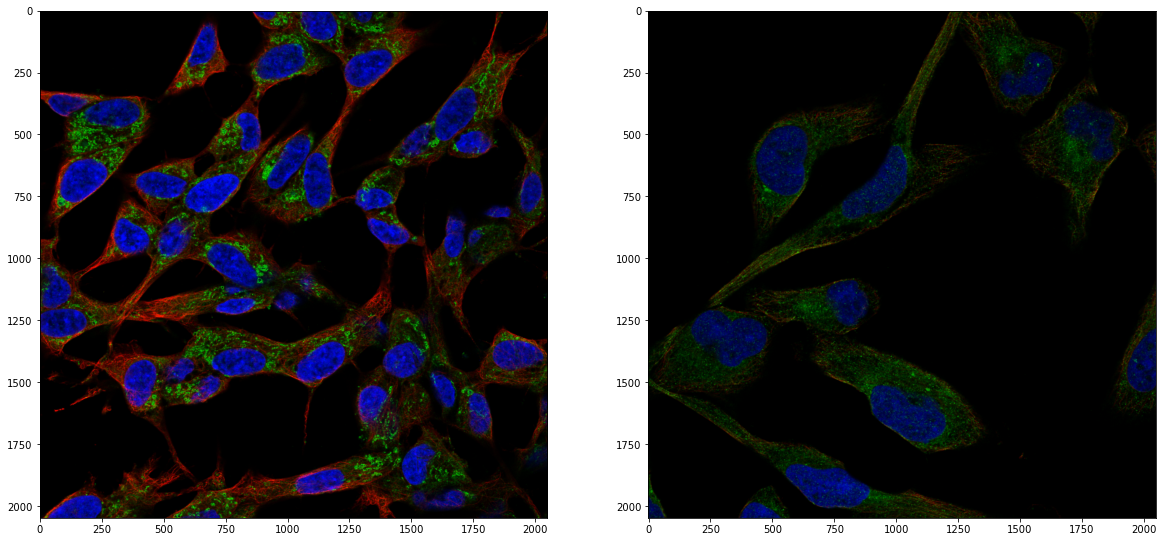

In [6]:
# view a couple RGBY-RGB converted images

SAVE_DIR = '../input/image_subset/image/'
rand = random.sample(sorted(X.ID), 2)
fig, ax = plt.subplots(1,2, figsize=(20,50))
ax[0].imshow(Image.open(SAVE_DIR+rand[0]+'.png'))
ax[1].imshow(Image.open(SAVE_DIR+rand[1]+'.png'))
plt.show()

## Transformers

[Custom Transformers Pytorch](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

Most nueral networks expect the image to be fixed size. Therefore we will need to some preprocessing code.

Augmentation can also be included in this step. Randomly cropping or changing contrast etc can be useful to help the model generalize well. I will not include any augmentation in this notebook. Clink on the link for some examples of augmentation.

For our transormation we are going to rescale and transform into a tensor.

**NB I haven't included a Normalization transformer yet, I wasn't sure how to find the best mean and std. Maybe you have some thoughts? A second NB may be in order for the best transformers.**

<code>transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
</code>

**NB2 The color mask needs to be resized before it can be split, tensors are hard to resize. Therefore transformer should go rescale -> add bounding box/ area-> totensor(img) **

In [107]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple)) # check output size is 
                                                     # right format
        self.output_size = output_size

    def __call__(self, sample):
        
        image, target = sample['image'], sample['target']
        
        w, h = image.size 
        
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        
        #resize iamge
        img = image.resize((new_h, new_w))
        #resize mask image
        target['masks'] = target['masks'].resize((new_h, new_w))
        return {'image': img, 'target': target}
    


class ToTensor(object):
    """Custom to tensor class, does not accept dictionary."""

    def __call__(self, sample):
        image, target = sample['image'], sample['target']
        # torch image: C X H X W
        image = transforms.ToTensor()(image)
        return {'image': image, 'target': target}

    
class split_mask_bounding_box_area(object):
    """Custom to tensor class, does not accept dictionary."""

    def __call__(self, sample):
        image, target = sample['image'], sample['target']
        
        # load target
        mask = target['masks']
        # convert to array for individual segments
        mask = np.array(mask)
        # split into different segmentations
        obj_ids = np.unique(mask)
        # 0 is background, get rid
        obj_ids = obj_ids[1:]
        
        # split color-encoded mask into
        # a set of binary masks
        
        masks = mask == obj_ids[:, None, None] # HOW DOES THIS WORK
        
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
             
        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # there is only one class in picture
        # this is how the dataset is defined
        label = target['labels']
        # tensor of labels
        labels = torch.tensor([int(label)]*num_objs, dtype=torch.int64)
        
        # tensor masks
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        
        # area of box
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        # define target
        target["masks"] = masks
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area

        return {'image': image, 'target': target}

In [125]:
# define transforms
def get_transform():
    custom_transforms = [Rescale(512),
                         split_mask_bounding_box_area(),
                         ToTensor()]
    return torchvision.transforms.Compose(custom_transforms)

Now let's build the dataset and loader with transformers and new RGB images.

In [120]:
# define labels as a dictionary
map_labels={
    0: 1,
    14: 2,
    16: 3
}

labels = dict(zip(X.ID, X.Label.apply(lambda x: map_labels[x])))

In [121]:
class HPAImageDataset(object):
    
    
    def __init__(self, root, transforms, labels):
        self.root = root
        self.transforms = transforms
        # sort in order to make sure they
        # are aligned
        self.labels = labels # dictionary {'ID': 'label'}
        self.imgs = list(sorted(os.listdir(os.path.join(root, 'image'))))
        self.masks = list(sorted(os.listdir(os.path.join(root, 'mask'))))
                          
                          
    def __len__(self):
        return(len(self.imgs))
                          
    
    def __getitem__(self, idx):
        # load images and masks for idx
        img_path = os.path.join(self.root, "image", self.imgs[idx])
        mask_path = os.path.join(self.root, "mask", self.masks[idx])
        # open img in PIL
        img = Image.open(img_path)
        # load mask
        mask = Image.open(mask_path)
        
        #define target
        target = {}
        # set image id and mask
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        target["masks"] = mask
        # label there is only one class in picture
        # this is how the dataset is defined
        label = self.labels[os.path.basename(img_path[:-4])]
        target["labels"] = label
        
        if self.transforms is not None:
            # torchvision compose only accepts single input
            sample = {'image': img, 'target': target}
            sample = self.transforms({'image': img, 'target': target})
            img, target = sample['image'], sample['target']

        return(img, target)  

In [122]:
ROOT_DIR = '../input/image_subset/'
# create own Dataset
transformed_dataset = HPAImageDataset(root=ROOT_DIR,
                          transforms=get_transform(),
                          labels=labels,
                          )

1000 torch.Size([3, 512, 512]) torch.Size([28, 4]) torch.Size([28]) torch.Size([28, 512, 512]) tensor([1])
1001 torch.Size([3, 512, 512]) torch.Size([17, 4]) torch.Size([17]) torch.Size([17, 512, 512]) tensor([3])
1002 torch.Size([3, 512, 512]) torch.Size([10, 4]) torch.Size([10]) torch.Size([10, 512, 512]) tensor([2])
1003 torch.Size([3, 512, 512]) torch.Size([33, 4]) torch.Size([33]) torch.Size([33, 512, 512]) tensor([3])
1004 torch.Size([3, 512, 512]) torch.Size([14, 4]) torch.Size([14]) torch.Size([14, 512, 512]) tensor([1])
1005 torch.Size([3, 512, 512]) torch.Size([11, 4]) torch.Size([11]) torch.Size([11, 512, 512]) tensor([1])
1006 torch.Size([3, 512, 512]) torch.Size([74, 4]) torch.Size([74]) torch.Size([74, 512, 512]) tensor([2])
1007 torch.Size([3, 512, 512]) torch.Size([19, 4]) torch.Size([19]) torch.Size([19, 512, 512]) tensor([1])
1008 torch.Size([3, 512, 512]) torch.Size([12, 4]) torch.Size([12]) torch.Size([12, 512, 512]) tensor([1])
1009 torch.Size([3, 512, 512]) torch.

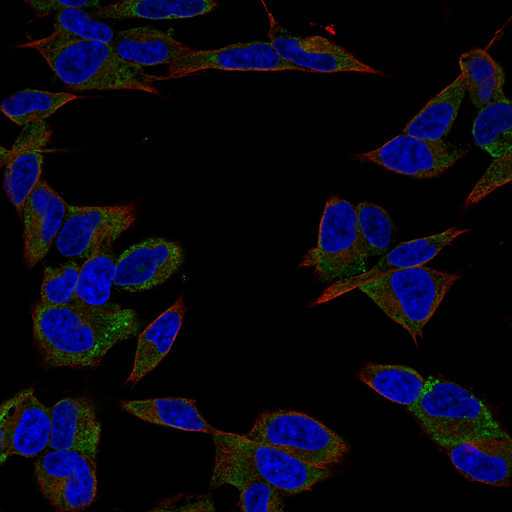

In [133]:
# test dataset
for i in range(1000,1010):
    img, target = transformed_dataset[i]

    print(i, img.size(), target['boxes'].size(), target['area'].size(), 
          target['masks'].size(),target['labels'].unique())

view = transforms.ToPILImage(mode='RGB')(img) #convert from tensor for viewing.
view # un normalized so we can view this froms source.

## Dataloader

[Speeding up Dataloader stackoverflow](https://stackoverflow.com/questions/61393613/pytorch-speed-up-data-loading)

The dataloader is really really slow for some reason, if you can work that out let me know.

I am going to do some testing on a subset of the data. Only 5 images long.

[Example Pytorch](https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html?highlight=dataset)

In [146]:
sub_dataset = torch.utils.data.Subset(transformed_dataset, list(range(5)))

for i in range(len(sub_dataset)):
    img, target = transformed_dataset[i]

    print(i, img.size(), target['boxes'].size(), target['area'].size(), 
          target['masks'].size(),target['labels'].unique())

0 torch.Size([3, 512, 512]) torch.Size([20, 4]) torch.Size([20]) torch.Size([20, 512, 512]) tensor([1])
1 torch.Size([3, 512, 512]) torch.Size([37, 4]) torch.Size([37]) torch.Size([37, 512, 512]) tensor([2])
2 torch.Size([3, 512, 512]) torch.Size([21, 4]) torch.Size([21]) torch.Size([21, 512, 512]) tensor([3])
3 torch.Size([3, 512, 512]) torch.Size([16, 4]) torch.Size([16]) torch.Size([16, 512, 512]) tensor([1])
4 torch.Size([3, 512, 512]) torch.Size([24, 4]) torch.Size([24]) torch.Size([24, 512, 512]) tensor([2])


In [132]:
# collate_fn needs for batch
# def collate_fn(batch):
#     return tuple(zip(*batch))

# batch size
train_batch_size = 64

# own dataLoader tester
data_loader = torch.utils.data.DataLoader(sub_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True)

In [147]:
for i_batch, sample_batched in enumerate(data_loader):
    print(i_batch, sample_batched['image'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        break

RuntimeError: stack expects each tensor to be equal size, but got [18, 512, 512] at entry 0 and [19, 512, 512] at entry 1